In [78]:
import os
import numpy as np

dataset_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_100000.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"

output_results_path = os.environ["DATA"] + "/07_BBO/02_models/paper/02.02_GPR_HOMO_QM9_data_efficiency_larger_test_set/"
output_figures_path = os.environ["FIGURES"] + "/07_BBO/02_models/paper/02.02_GPR_HOMO_QM9_data_efficiency_larger_test_set/"

# dft_path = os.environ["DFT_COMPUT_RDKIT_MM"]

TOTAL_DATASET_SIZE = 10000
N_MOL = [10, 30, 100, 300, 1000, 3000]

CV_EXTERNAL = 10

N_JOBS=10

MM_program = "rdkit"

models_to_run = {
#     ("1.0*SOAP( xi=2)", "SOAP"): [1e-1, 1e0],
    ("1.0*RBF( 1.0)", "MBTR"): [1e-1, 1e0],
#     ("1.0*DotProduct( sigma_0=1)", "MBTR"): [1e-2, 1e-1],
    ("1.0*DotProduct( sigma_0=1)", "Shingles count"): [1e-1, 1e0]
}

dft_path = "/tmp"


In [79]:
from bbo.objective import EvoMolEvaluationStrategyWrapper
from evomol.evomol.evaluation_dft import OPTEvaluationStrategy

objective = EvoMolEvaluationStrategyWrapper(
    OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                          working_dir_path=dft_path,
                          MM_program=MM_program))

133798 molecules in cache


In [80]:
from os import makedirs

makedirs(output_results_path, exist_ok=True)
makedirs(output_figures_path, exist_ok=True)

In [81]:
import numpy as np
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel

class SOAPKernelVectorized(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(self, xi=2):
        self.xi = xi
        
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            Y = X
            
        # Extracting the dimensions of both matrices
        X_dim = X.shape[0]
        Y_dim = Y.shape[0]

        # Computing the dot product of each matrix with itself and with the other
        dot_X_X = X.dot(X.T)
        dot_X_Y = X.dot(Y.T)
        dot_Y_Y = Y.dot(Y.T)

        # Extracting the dot product of each element of each matrix with itself
        diag_X = np.diag(dot_X_X)
        diag_Y = np.diag(dot_Y_Y)

        # Building the matrix of dimension (X_dim, Y_dim) containing in each line the dot product of the nth
        # element of X with itself
        X_dot_matrix = np.tile(diag_X, Y_dim).reshape((Y_dim, X_dim)).T

        # Building the matrix of dimension (X_dim, Y_dim) containing in each column the dot product of the nth
        # element of Y with itself
        Y_dot_matrix = np.tile(diag_Y, X_dim).reshape((X_dim, Y_dim))

        # Computing the SOAP kernel of X and Y
        K = (dot_X_Y/np.sqrt(X_dot_matrix * Y_dot_matrix))**self.xi
        
        if np.sum(np.isinf(K)) > 0:
            print("Inf values in kernel")
            
        if np.sum(np.isnan(K)) > 0:
            print("Nan values in kernel")
        
        # Replacing possible nan values due to zero by zero division
        K[np.isnan(K)] = 0
        
        if eval_gradient:
            return K, np.empty((X.shape[0], X.shape[0], 0))
        else:
            return K
    

    def get_params(self, deep=True):
        return {"xi": self.xi}
    
    def __repr__(self):
        return "{0}(xi={1:.3g})".format(self.__class__.__name__, self.xi)


In [82]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct


kernels = [("1.0*RBF( 1.0)", 1.0*RBF(1.0)),
           ("1.0*DotProduct( sigma_0=1)", 1.0*DotProduct(sigma_0=1)),
           ("1.0*SOAP( xi=2)", 1.0*SOAPKernelVectorized(xi=2))]


models = []
for kernel in kernels:
    models.append((kernel[0], GaussianProcessRegressor(kernel=kernel[1],
                                                       optimizer="fmin_l_bfgs_b")))


In [83]:
from bbo.descriptor import SOAPDesc, ShinglesVectDesc, MBTRDesc, CoulombMatrixDesc

descriptors_mm = [
    ("SOAP", SOAPDesc(cache_location=None, n_jobs=N_JOBS, average="inner", rcut=4, nmax=5, 
                      lmax=6, species=["C", "H", "O", "N", "F"], MM_program=MM_program)),
    ("MBTR", MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                      inverse_distances_n=25, species=["C", "H", "O", "N", "F"], MM_program=MM_program)), 
    ("Shingles count", ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)),
#     ("CM", CoulombMatrixDesc(n_atoms_max=29, cache_location=None, n_jobs=N_JOBS, MM_program=MM_program)),
]
    

In [84]:
from os.path import join
import numpy as np
from sklearn.preprocessing import normalize, scale


def compute_desc_obj(smiles_list, desc_builder, objective):
    
    X, success = desc_builder.transform(smiles_list)
    X = X[success]
    
    smiles_list_filtered = np.array(smiles_list)[success]
    
    y, all_scores, success, comput_times = objective.transform(smiles_list_filtered)
    
    smiles_list_filtered = np.array(smiles_list_filtered)[success]
    
    return X[success], y[success], smiles_list_filtered
    

In [85]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from os.path import join
import json

def train_models_alpha_value(X, y, desc_name, model_name, model, preprocessing, geometry_type, dataset_size, 
                             alpha_value, output_path):
    
    experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type + "-" + str(dataset_size) + "-" + str(alpha_value)
    experiment_output_json = join(output_path, experiment_name + ".json")

    if preprocessing is not None:
        pipeline = Pipeline([
            ("Preprocessing", preprocessing),
            ("model", model)
        ])
    else:
        pipeline = Pipeline([
            ("model", model)
        ])

    # Setting scoring metrics
    scoring = {
        "MAE": "neg_mean_absolute_error",
        "RMSE": "neg_root_mean_squared_error"
    }
    
    # Setting alpha value to the model
    pipeline.set_params(
        model__alpha = alpha_value,
    )
    
    print(pipeline)
    

    # Performing cross validation (external CV)
    scores = cross_validate(estimator=pipeline, X=X, y=y, scoring=scoring,
                            cv=ShuffleSplit(n_splits=CV_EXTERNAL, train_size=dataset_size, random_state=42), 
                            n_jobs=N_JOBS, verbose=3, return_estimator=True)

    print(scores)

    # Computing output dictionary
    output_dict = {
        "exp_name": experiment_name,
        "mean_mae": float(- scores["test_MAE"].mean()),
        "mae_values": (- scores["test_MAE"]).tolist(),
        "mean_rmse": float(- scores["test_RMSE"].mean()),
        "rmse_values": (- scores["test_RMSE"]).tolist(),
        "mean_fit_time": scores["fit_time"].mean(),
        "fit_times": scores["fit_time"].tolist(),
        "mean_score_time": scores["score_time"].mean(),
        "score_times": scores["score_time"].tolist()
    }
    
    print(output_dict)

    # Writing output json file to disk
    with open(experiment_output_json, "w") as f:
        json.dump(output_dict, f, indent=4)


def train_models_dataset_size(models, X, y, descriptor_name, objective, dataset_path, output_path, 
                              geometry_type, dataset_size, preprocessing=None):
    
        
    # Iteration over all models
    for model_tuple in models:

        model_name, model = model_tuple

        # Checking that experiment must be run
        if (model_name, descriptor_name) in models_to_run:

            # Extracting alpha values for given model
            alpha_values = models_to_run[(model_name, descriptor_name)]

            # Iterating over alpha values
            for alpha_value in alpha_values:

                # Performing experiments for given dataset size and alpha value
                train_models_alpha_value(X=X, y=y, desc_name=descriptor_name, model_name=model_name, 
                                         model=model, preprocessing=preprocessing, 
                                         geometry_type=geometry_type, dataset_size=dataset_size, 
                                         alpha_value=alpha_value, output_path=output_path)

                
                
def train_all_models(models, descriptors, objective, dataset_path, output_path, geometry_type, dataset_sizes, 
                     preprocessing):
    
    # Extracting required number of SMILES
    total_smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:TOTAL_DATASET_SIZE]:
            total_smiles_list.append(smi.rstrip())
    
    # Iterating over all descriptors
    for descriptor_tuple in descriptors:
        
        desc_name, desc_builder = descriptor_tuple
                
        # Computing descriptors and objective values for current descriptor 
        X, y, smiles_list_filtered = compute_desc_obj(total_smiles_list, desc_builder, objective)
    
        # Iterating over all dataset sizes
        for dataset_size in dataset_sizes:
            train_models_dataset_size(models=models, descriptor_name=desc_name, X=X, y=y, 
                                      objective=objective, dataset_path=dataset_path, 
                                      output_path=output_path, geometry_type=geometry_type, 
                                      dataset_size=dataset_size, preprocessing=preprocessing)

In [86]:
# train_all_models(models=models, descriptors=descriptors_mm, objective=objective, dataset_path=dataset_path, 
#                  output_path=output_results_path, geometry_type="MM", dataset_sizes=N_MOL, preprocessing=None)

In [87]:
import time

def comput_desc_time(descriptors, size):
    
    # Extracting required number of SMILES
    total_smiles_list = []
    with open(dataset_path, "r") as f:
        for smi in f.readlines()[:size]:
            total_smiles_list.append(smi.rstrip())
    
    for desc_tuple in descriptors:
        
        desc_name, desc_builder = desc_tuple
        desc_builder.n_jobs = 1

        tstart = time.time()
        desc_builder.fit_transform(total_smiles_list)
        time_comput = time.time() - tstart
        
        with open(join(output_results_path, desc_name + "-" + str(size) + ".txt"), "w") as f:
            f.writelines([str(time_comput)])

In [88]:
comput_desc_time(descriptors_mm, 100)

In [89]:
def extract_fit_time(descriptors, size):
    
    fit_times = {}
    
    for desc_tuple in descriptors:
        
        desc_name, _ = desc_tuple
        
        path = join(output_results_path, desc_name + "-" + str(size) + ".txt")
        with open(path, "r") as f:
            fit_times[desc_name] = float(f.readline())
            
    return fit_times
    

In [90]:
fit_times_100 = extract_fit_time(descriptors_mm, 100)

print(fit_times_100)

{'SOAP': 136.07588124275208, 'MBTR': 150.3483908176422, 'Shingles count': 4.353700876235962}


In [91]:
import json
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)


def init_results_dict(models, descriptors):
    
    results_dict = {}
    results_dict["kernel"] = [model[0] for model in models]
    for descriptor in descriptors:
        results_dict[descriptor[0]] = []
    
    return results_dict

def display_dict(name, d):
    display(HTML('<h3>' + name +'</h3>'))
    display(pd.DataFrame.from_dict(d))
    

def extract_results(json_path):
    
    with open(json_path, "r") as f:
        json_dict = json.load(f)
        
        mean_mae = json_dict["mean_mae"]
        mae_values = json_dict["mae_values"]
        mean_rmse = json_dict["mean_rmse"]
        rmse_values = json_dict["rmse_values"]
        mean_fit_time = json_dict["mean_fit_time"]
        fit_times = json_dict["fit_times"]
        
    return mean_mae, mae_values, mean_rmse, rmse_values, mean_fit_time, fit_times

    
def plot_values_subplot(mae_dict, time_dict):
    
    plt.xlim((0, 1))
    plt.ylim((1, 10000))
    plt.xlabel("MAE (eV)")
    plt.ylabel("time (s)")
    plt.yscale("log")
    
    pd_dict= {
        "x_values": [],
        "y_values": [],
        "kernel_values": [],
        "desc_values": [],
    }
    
    colors = sns.color_palette()
    markers = ['s', '^', 'o', '+', 'x']
    
    all_kernels = list(mae_dict["kernel"])
    all_desc = []
    for i, key in enumerate(mae_dict.keys()):
        
        if key != "kernel":
            
            all_desc.append(key)
            
            for j in range(len(kernels)):
                
                pd_dict["x_values"].append(mae_dict[key][j])
                pd_dict["y_values"].append(time_dict[key][j])
                pd_dict["kernel_values"].append(all_kernels[j])
                pd_dict["desc_values"].append(key)

        
    sns.scatterplot(data=pd_dict, x="x_values", y="y_values", hue="kernel_values", style="desc_values")
    
    

def extract_values(models, descriptors, results_root, geometry_type, preprocessing, dataset_sizes):
    
    results_dict = {}

    # Iterating over dataset sizes
    for dataset_size in dataset_sizes:
        
        results_dict[dataset_size] = {}
    
        # Iterating over all descriptors
        for desc_tuple in descriptors:

            desc_name, _ = desc_tuple
            
            results_dict[dataset_size][desc_name] = {
                "model": {}
            }
            
            # Iterating over all models
            for model_tuple in models:
                
                model_name, _ = model_tuple
                
                # Checking that there is data for current model
                if (model_name, desc_name) in models_to_run:
                    
                    results_dict[dataset_size][desc_name]["model"][model_name] = {}
                    
                    # Iterating over alpha values for current model
                    for i, alpha_value in enumerate(models_to_run[(model_name, desc_name)]):
                        
                        # Computing model path
                        experiment_name = desc_name + "-" + model_name + "-" + str(preprocessing) + "-" + geometry_type + "-" + str(dataset_size) + "-" + str(alpha_value)
                        path = join(output_results_path, experiment_name + ".json")
                        
                        # Extracting results
                        mean_mae, mae_values, mean_rmse, rmse_values, mean_fit_time, fit_times = extract_results(path)
                        
                        results_dict[dataset_size][desc_name]["model"][model_name][i] = {
                            "mean_mae": mean_mae,
                            "mae_values": mae_values,
                            "mean_rmse": mean_rmse,
                            "rmse_values": rmse_values,
                            "mean_fit_time": mean_fit_time,
                            "fit_times": fit_times
                        }

    return results_dict
                

# MM results 



In [92]:
results_dict = extract_values(models, descriptors_mm, output_results_path, "MM", None, N_MOL)

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

def desc_kernel_to_model_name(desc_name, kernel_name):
    
    if desc_name == "Shingles count":
        desc = "Shingles"
    else:
        desc = desc_name

    if kernel_name == "1.0*SOAP( xi=2)":
        kernel = "SOAP"
    elif kernel_name == "1.0*RBF( 1.0)":
        kernel = "RBF"
    elif kernel_name == "1.0*DotProduct( sigma_0=1)":
        kernel = "·"
    
    return "("+desc+"," + kernel +")"

def plot_data_efficiency(results_dict, fit_times_100):
    
    pd_dict = {
        "Dataset size": [],
        "MAE (eV)": [],
        "RMSE (eV)": [],
        "Fit time (s)": [],
        "Fit + 500 desc. time (s)": [],
        "Model": [],
        "Noise": [],
        "run": []
    }
    
    for dataset_size in results_dict.keys():
        
        for desc_name in list(results_dict[dataset_size].keys())[::-1]:
            
            for model_name in results_dict[dataset_size][desc_name]["model"].keys():
                
                for alpha_geom in results_dict[dataset_size][desc_name]["model"][model_name].keys():
                    
                    if alpha_geom == 0:
                
                        mae_values = results_dict[dataset_size][desc_name]["model"][model_name][alpha_geom]["mae_values"]
                        rmse_values = results_dict[dataset_size][desc_name]["model"][model_name][alpha_geom]["rmse_values"]
                        fit_times = results_dict[dataset_size][desc_name]["model"][model_name][alpha_geom]["fit_times"]
                        fit_times_desc_100 = list(np.array(fit_times) + fit_times_100[desc_name])
                        for i in range(CV_EXTERNAL):

                            pd_dict["Dataset size"].append(dataset_size)
                            pd_dict["MAE (eV)"].append(mae_values[i])
                            pd_dict["RMSE (eV)"].append(rmse_values[i])
                            pd_dict["Fit time (s)"].append(fit_times[i])
                            pd_dict["Fit + 500 desc. time (s)"].append(fit_times_desc_100[i])
                            pd_dict["run"].append(i)
                            pd_dict["Noise"].append("optimal noise 3000" + " * " + str(10**alpha_geom))
                            pd_dict["Model"].append(desc_kernel_to_model_name(desc_name, model_name))

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=pd_dict, x="Dataset size", y="MAE (eV)", hue="Model")#, style="Noise")
    plt.xscale("log")
    plt.xlabel("Dataset size")
    plt.ylabel("MAE (eV)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_MAE.png"), dpi=300)
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=pd_dict, x="Dataset size", y="RMSE (eV)", hue="Model")#, style="Noise")
    plt.xscale("log")
    plt.xlabel("Dataset size")
    plt.ylabel("RMSE (eV)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_RMSE.png"), dpi=300)
    
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=pd_dict, x="Dataset size", y="Fit time (s)", hue="Model")#, style="Noise")
    plt.xlabel("Dataset size")
    plt.ylabel("Fit time (s)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_time.png"), dpi=300)
    
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=pd_dict, x="Dataset size", y="Fit + 500 desc. time (s)", hue="Model")#, style="Noise")
    plt.xlabel("Dataset size")
    plt.ylabel("Fit + 500 desc. time (s)")
    plt.legend()
    plt.savefig(join(output_figures_path, "efficiency_time_+_500_desc.png"), dpi=300)
    
    
    
    

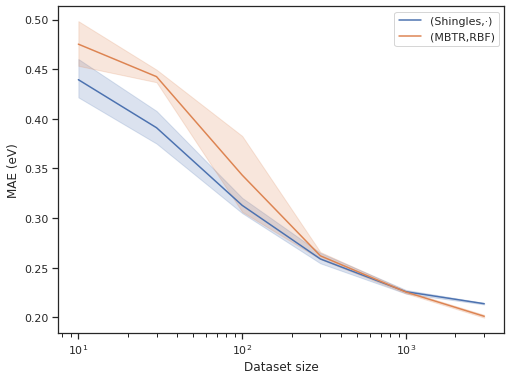

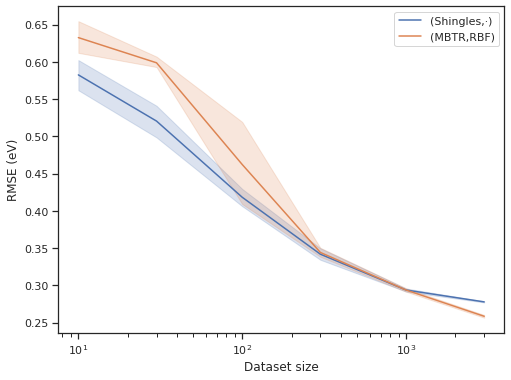

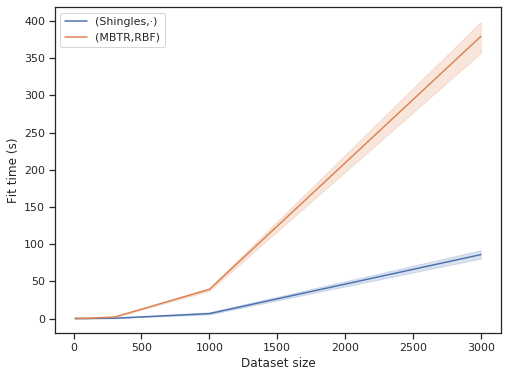

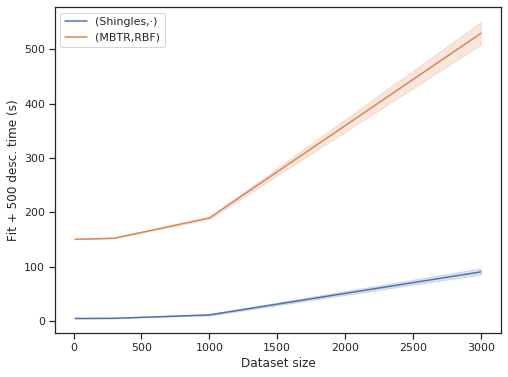

In [94]:
plot_data_efficiency(results_dict, fit_times_100)